In [1]:
# import necessary library
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from numpy import arange
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

In [2]:
# import dataset
df = pd.read_csv('/Users/ngocnguyen/Dropbox/Mac/Desktop/SQL/listing_cleaned.csv')

In [3]:
# Dependent variable
var_dep = ['price']

# Categorical variables
vars_category = [var for var in df.columns if df[var].dtype != 'float' and df[var].dtype != 'int']

# Numerical variables
vars_numeric = [var for var in df.columns if var not in var_dep + vars_category]

# Indepedent variables
vars_ind = vars_category + vars_numeric

# split train and test set
X = df[vars_ind]
y = df[var_dep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [4]:
# create index for train, validate, and test dataset
np.random.seed(4)
df_train = pd.concat([X_train,y_train],axis=1)

df_train['fold'] = np.random.randint(0,8,df_train.shape[0])

idx_train  = df_train['fold'].isin(range(6))
idx_val    = df_train['fold'].isin([6,7])
idx_design = df_train['fold'].isin(range(8))

df_X_all = df_train[idx_design][vars_ind]
y = df_train[var_dep].values

In [5]:
import time 


# recording time
start = time.time()
import hyperopt

def hyperopt_objective(params):
    model = CatBoostRegressor(iterations=3000,                     # Building max of 4000 trees
                            use_best_model=True,                   # Use validation to choose best model
                            eval_metric='RMSE',                    # Use RMSE as a metric 
                            od_type='Iter',                        # To prevent overfitting
                            od_wait=20,                            # If after 20 steps, local minimum has not changed then stop
                            border_count=128,                      # Only split a numerical variable 128 times
                            model_size_reg=0,                      # Parameter set to be similar with GPU
                            ctr_leaf_count_limit=None,             # No leaf count limit
                            leaf_estimation_method = 'Gradient',   # Using Gradient metric
                            max_ctr_complexity=4,                  # Set similar to GPU
                            learning_rate=0.03,                    # Learning rate as 0.03

                            boosting_type='Plain',                 # Set boosting type
                            bootstrap_type='Bernoulli',            # Bootstraping type
                            one_hot_max_size=5,                    # Max 10 dummy variables
                            task_type='CPU',                       # Set as CPU
                            depth=params['depth'],                 # Level of depth 
                            l2_leaf_reg=params['l2_leaf_reg'],     # Level of penalization
                            loss_function='RMSE',                  # Metric set as RMSE
                            random_seed=14,                        # Reproducible
                            logging_level='Silent'                 # No need to print out anything
                            )


    cv_data = cv(Pool(df_X_all[idx_design],                        # extracting the cross_validation results
                      y[idx_design], 
                      cat_features=vars_category),
                      model.get_params())
    
    idx_best_val = cv_data['test-RMSE-mean'].idxmin()              # find idx when validation set is lowest
    val_loss = cv_data.loc[idx_best_val, 'test-RMSE-mean']         # find its validation error value
    train_loss = cv_data.loc[idx_best_val, 'train-RMSE-mean']      # find its train error value
    penalised_loss = val_loss + 0.1 * np.maximum(0, val_loss - train_loss - 1) + 0.1 * np.maximum(0, val_loss - train_loss - 5)   # formula to penalize overfitting 
    return penalised_loss 
# RandomState
from numpy.random import RandomState


# params_space to randomly select parameters to put into training model
params_space = {
    'l2_leaf_reg': 30+hyperopt.hp.randint('l2_leaf_reg', 2)*30,       # only choose 2 values due to cost of running time (5, 30) a standard range for l2_leaf_reg
    'depth': 6 + hyperopt.hp.randint('depth', 2)*6,                   # only choose 2 values due to cost of running time (11,3) a range of either overfitting or underfitting
} 


# hyperopt Trials
trials = hyperopt.Trials()                            # Trials


best = hyperopt.fmin(hyperopt_objective,              # input its objective
                     space=params_space,              # randomly inputing value of its params_space
                     algo=hyperopt.tpe.suggest,       # algorithm of hyperopt
                     max_evals=4,                     # trying 10 combination of values
                     trials=trials,                   # algorithm of hyperopt
                     rstate=RandomState(14)           # reproducible
)

print(best)                                           # print out the best parameters

end_time = time.time() - start                        # end time of running
print(end_time)

100%|██████████| 4/4 [56:07<00:00, 842.00s/trial, best loss: 30.678582459630274]
{'depth': 0, 'l2_leaf_reg': 0}
3370.134890794754


In [6]:
# The Catboost model with selected parameters on training set
model2 = CatBoostRegressor(iterations=3000,                     # Building max of 4000 trees
                        use_best_model=True,                   # Use validation to choose best model
                        eval_metric='RMSE',                    # Use RMSE as a metric 
                        od_type='Iter',                        # To prevent overfitting
                        od_wait=20,                            # If after 20 steps, local minimum has not changed then stop
                        border_count=128,                      # Only split a numerical variable 128 times
                        model_size_reg=0,                      # Parameter set to be similar with GPU
                        ctr_leaf_count_limit=None,             # No leaf count limit
                        leaf_estimation_method = 'Gradient',   # Using Gradient metric
                        max_ctr_complexity=4,                  # Set similar to GPU
                        learning_rate=0.03,                    # Learning rate as 0.03

                        boosting_type='Plain',                 # Set boosting type
                        bootstrap_type='Bernoulli',            # Bootstraping type
                        one_hot_max_size=5,                    # Max 10 dummy variables
                        task_type='CPU',                       # Set as CPU
                        depth=6,                               # Level of depth 
                        l2_leaf_reg=30,                        # Level of penalize 
                        loss_function='RMSE',                  # Metric set as RMSE
                        random_seed=14,                        # Reproducible
                        logging_level='Silent'                 # No need to print out anything
                        )

# Fit the model
model2.fit(df_X_all[idx_design], y[idx_design],
            cat_features=vars_category,
            eval_set=(df_X_all[idx_val], y[idx_val]),
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [7]:
# Calculating MAE between predictions and true labels
def fn_MAE(actuals, predictions):
    
    return np.mean(np.abs(predictions - actuals))

# Calculating RMSE between predictions and true labels
def fn_RMSE(actuals, predictions):
    return np.sqrt(np.mean((predictions - actuals)**2))


In [8]:
# Calculating MAE and RMSE of validation error
pred_val   = model2.predict(df_X_all[idx_val])
print('MAE val error',   fn_MAE(y[idx_val],   pred_val))
print('RMSE val error', fn_RMSE(y[idx_val],   pred_val))

MAE val error 48.45179716058062
RMSE val error 61.2497042580032


In [9]:
pred_test   = model2.predict(X_test)
r2_score(y_test, pred_test)

0.6068843942063749

In [10]:
print('MAE test error',   fn_MAE(y_test.values, pred_test))
print('RMSE test error', fn_RMSE(y_test.values, pred_test))

MAE test error 47.65307227130725
RMSE test error 60.33524033217221


Text(0.5, 1.0, 'Variable Importance')

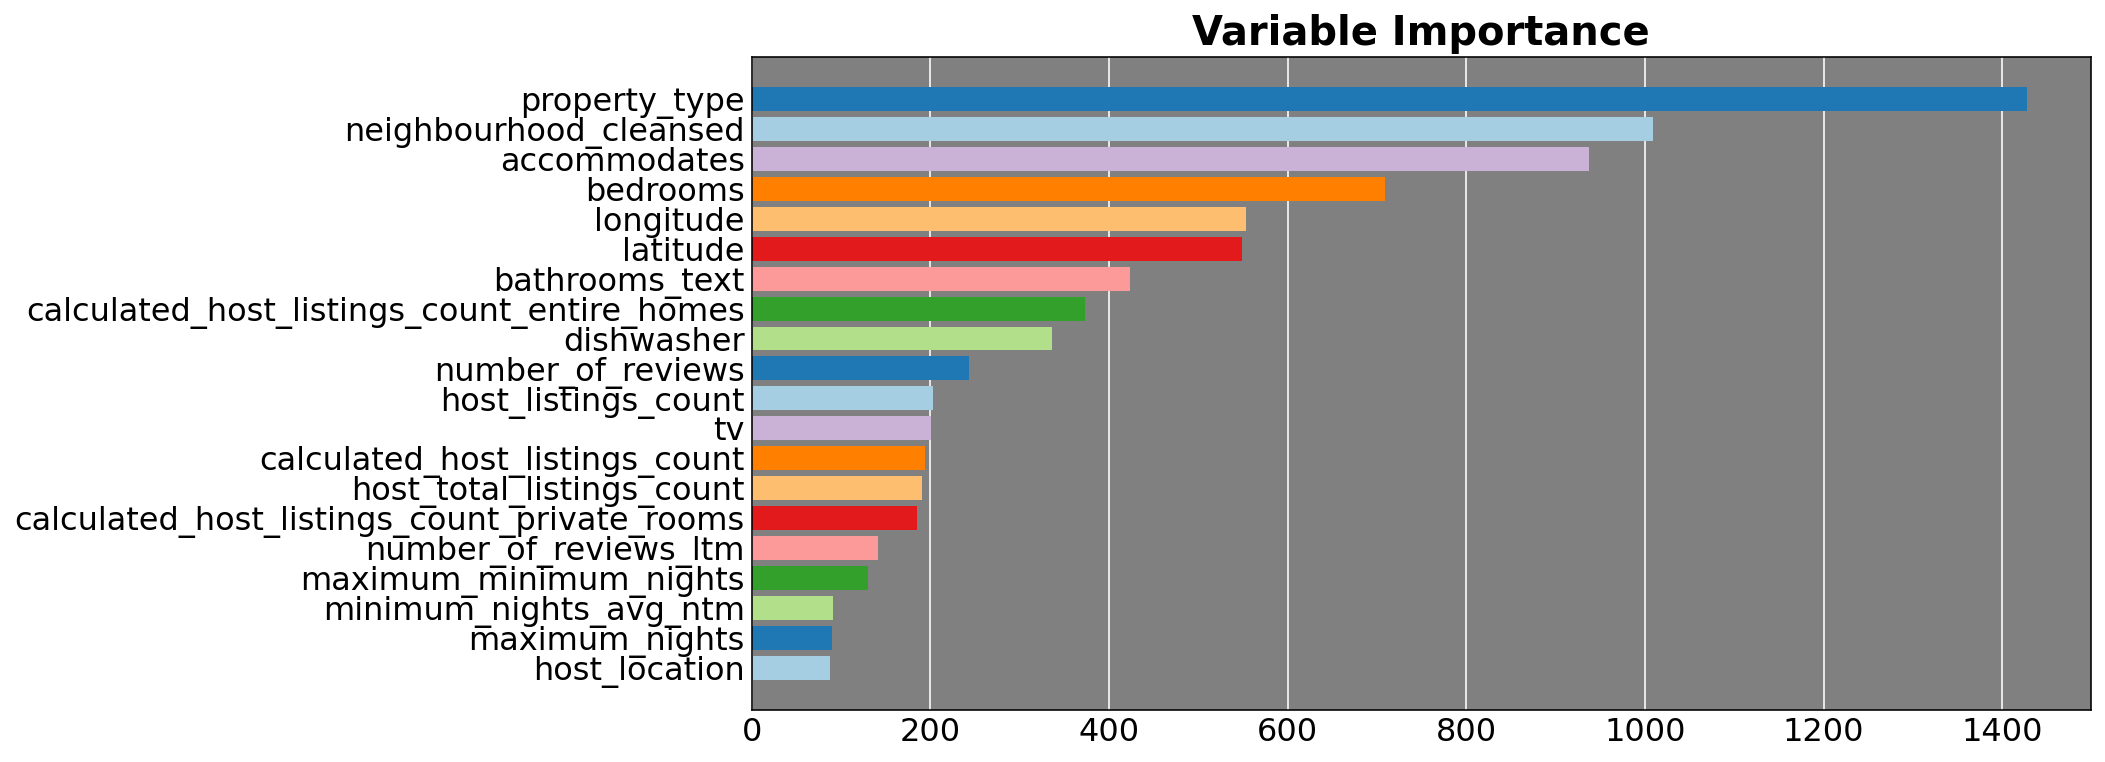

In [11]:
# Visualise variable important
scores = model2.feature_importances_.tolist()
column_name = X_train.columns.tolist()

# Barchart to visualize
barchart = pd.DataFrame({'variables':column_name,'scores':scores})

# Re-aranging by sorting via level of importance
barchart = barchart.sort_values('scores',ascending=True)
barchart = barchart.tail(20)
barchart['scores'] = barchart['scores']*100

fig, ax = plt.subplots(figsize=(12, 6), dpi=144)
colors = plt.cm.Paired(range(9))
y = barchart.variables
width = barchart.scores

ax.barh(y=y, width=width, color=colors)
ax.set_facecolor('.5')
ax.tick_params(labelsize=16, length=0)
ax.grid(True,axis='x',color='white')
ax.set_axisbelow(True)
ax.set_title('Variable Importance',fontsize=20,fontweight=600)